## Document to Knowledge Graph Conversion using REBEL

In [ ]:
import spacy
import math
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# Initialize SpaCy for sentence segmentation and dependency parsing
nlp = spacy.load("en_core_web_sm")

# Load the REBEL model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("Babelscape/rebel-large")
model = AutoModelForSeq2SeqLM.from_pretrained("Babelscape/rebel-large")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# KB class to manage relations
class KB:
    def __init__(self):
        self.relations = []

    def are_relations_equal(self, r1, r2):
        return all(r1[attr] == r2[attr] for attr in ["head", "type", "tail"])

    def exists_relation(self, r1):
        return any(self.are_relations_equal(r1, r2) for r2 in self.relations)

    def merge_relations(self, r1):
        r2 = [r for r in self.relations if self.are_relations_equal(r1, r)][0]
        spans_to_add = [span for span in r1["meta"]["spans"] if span not in r2["meta"]["spans"]]
        r2["meta"]["spans"] += spans_to_add

    def add_relation(self, r):
        if not self.exists_relation(r):
            self.relations.append(r)
        else:
            self.merge_relations(r)

    def print(self):
        print("Relations:")
        for r in self.relations:
            print(f"  {r}")

# Extract relations using SpaCy dependency parsing
def extract_spacy_relations(text):
    doc = nlp(text)
    relations = []

    for token in doc:
        if token.dep_ == "ROOT":  # The main verb in the sentence
            subject = [w for w in token.lefts if w.dep_ in ("nsubj", "nsubjpass")]
            obj = [w for w in token.rights if w.dep_ in ("dobj", "attr", "prep", "pobj")]
            if subject and obj:
                relations.append({
                    'head': subject[0].text,
                    'type': token.text,  # The verb as the relation type
                    'tail': obj[0].text,
                    'meta': {'sentence': text, 'spans': []}
                })
    return relations

# Extract relations from Rebel model output
def extract_relations_from_model_output(text, sentence):
    relations = []
    relation, subject, object_ = '', '', ''
    current = 'x'
    text_replaced = text.replace("<s>", "").replace("<pad>", "").replace("</s>", "")

    for token in text_replaced.split():
        if token == "<triplet>":
            current = 't'
            if relation and subject and object_:
                relations.append({
                    'head': subject.strip(),
                    'type': relation.strip(),
                    'tail': object_.strip(),
                    'meta': {'sentence': sentence, 'spans': []}
                })
                relation, subject, object_ = '', '', ''
        elif token == "<subj>":
            current = 's'
        elif token == "<obj>":
            current = 'o'
        else:
            if current == 't':
                subject += ' ' + token
            elif current == 's':
                object_ += ' ' + token
            elif current == 'o':
                relation += ' ' + token

    if subject and relation and object_:
        relations.append({
            'head': subject.strip(),
            'type': relation.strip(),
            'tail': object_.strip(),
            'meta': {'sentence': sentence, 'spans': []}
        })
    return relations

# Unified function to extract triples using both SpaCy and Rebel
def from_text_to_kb(text, kb, span_length=64):
    sentences = [sentence.strip() for sentence in text.split(".") if sentence.strip()]

    for sentence in sentences:
        # Extract relations using SpaCy
        spacy_relations = extract_spacy_relations(sentence)
        for relation in spacy_relations:
            kb.add_relation(relation)

        # Extract relations using Rebel
        inputs = tokenizer([sentence], return_tensors="pt")
        num_tokens = len(inputs["input_ids"][0])
        num_spans = math.ceil(num_tokens / span_length)
        overlap = math.ceil((num_spans * span_length - num_tokens) / max(num_spans - 1, 1))
        spans_boundaries = []
        start = 0
        for i in range(num_spans):
            spans_boundaries.append([start + span_length * i, start + span_length * (i + 1)])
            start -= overlap

        tensor_ids = [inputs["input_ids"][0][boundary[0]:boundary[1]] for boundary in spans_boundaries]
        tensor_masks = [inputs["attention_mask"][0][boundary[0]:boundary[1]] for boundary in spans_boundaries]
        inputs = {
            "input_ids": torch.stack(tensor_ids).to(device),
            "attention_mask": torch.stack(tensor_masks).to(device)
        }

        num_return_sequences = 5
        gen_kwargs = {
            "max_length": 512,
            "length_penalty": 1.0,
            "num_beams": 5,
            "num_return_sequences": num_return_sequences
        }

        generated_tokens = model.generate(**inputs, **gen_kwargs)
        decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=False)

        for i, sentence_pred in enumerate(decoded_preds):
            current_span_index = i // num_return_sequences
            relations = extract_relations_from_model_output(sentence_pred, sentence)
            for relation in relations:
                relation["meta"]["spans"] = [spans_boundaries[current_span_index]]
                kb.add_relation(relation)

    return kb

In [ ]:
from datasets import load_dataset
from tqdm import tqdm
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch
import os

# Load the SQuAD dataset

dataset = load_dataset("rajpurkar/squad")

# Prepare the dataset (for 20 rows)
def prepare_dataset(dataset):
    dataset = dataset.select(range(100))  # Select only the first 20 rows
    dataset = dataset.map(lambda x: {
        'user_input': x['question'],
        'reference': x['answers']['text'][0] if x['answers']['text'] else '',
        'response': '',  # Placeholder for the generated response
        'retrieved_contexts': [x['context']]  # Make sure this is a list of contexts
    })
    return dataset

# Prepare the dataset
prepared_dataset = prepare_dataset(dataset["train"])

# 2. **Initialize the Embedding Model**
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

# 3. **Create a FAISS Index from the Dataset's Contexts**
def create_faiss_index(dataset, embedding_model):
    contexts = [example['retrieved_contexts'][0] for example in dataset]
    context_embeddings = embedding_model.encode(contexts, convert_to_numpy=True)

    # Convert context embeddings to numpy array and create the FAISS index
    context_embeddings = context_embeddings.astype(np.float32)

    # Initialize FAISS index
    index = faiss.IndexFlatL2(context_embeddings.shape[1])  # L2 distance metric

    # Add embeddings to the index
    index.add(context_embeddings)

    return index

# Create FAISS index from the dataset
faiss_index = create_faiss_index(prepared_dataset, embedding_model)

# 4. **Retrieve Relevant Contexts from FAISS**
def retrieve_relevant_context(query, faiss_index, embedding_model, top_k=1):
    query_embedding = embedding_model.encode([query], convert_to_numpy=True)
    query_embedding = query_embedding.astype(np.float32).reshape(1, -1)

    # Perform a similarity search (retrieving top_k nearest contexts)
    distances, indices = faiss_index.search(query_embedding, top_k)

    return indices

# Initialize distilbart model and tokenizer for local inference
distilbart_model = AutoModelForSeq2SeqLM.from_pretrained("sshleifer/distilbart-cnn-12-6")
tokenizer = AutoTokenizer.from_pretrained("sshleifer/distilbart-cnn-12-6")

# 5. **Generate Responses with Retrieved Context**
def generate_rag_responses(dataset, faiss_index, distilbart_model, tokenizer, embedding_model):
    responses = []
    for example in tqdm(dataset):
        user_input = example['user_input']

        # Retrieve the most relevant context(s)
        relevant_indices = retrieve_relevant_context(user_input, faiss_index, embedding_model)
        relevant_contexts = [dataset[int(idx)]['retrieved_contexts'][0] for idx in relevant_indices[0]]  # Convert idx to int

        # Combine the user question and retrieved context for distilbart input
        combined_input = f"Question: {user_input}\nContext: {'. '.join(relevant_contexts)}"

        # Encode the input and generate a response
        inputs = tokenizer(combined_input, return_tensors="pt", truncation=True)
        outputs = distilbart_model.generate(**inputs)

        # Decode the generated output
        response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        responses.append(response)

    return responses

# Generate responses and add them to the 'response' column
responses = generate_rag_responses(prepared_dataset, faiss_index, distilbart_model, tokenizer, embedding_model)

# Fill the 'response' column with generated responses
for idx, response in enumerate(responses):
    prepared_dataset[idx]['response'] = response

# Print the first row to check the response
print(prepared_dataset[0])  # Print the first row to verify

In [ ]:
# DATASET PRE-PROCESSING

contexts = list()
questions = list()
answers = list()
count = 0

for entry in prepared_dataset:
  con = entry["context"]
  que = entry["question"]
  ans = entry["answers"]["text"]

# context already extracted
  if con in contexts:
    que_list = questions[count - 1]
    que_list.append(que)
    questions[count - 1] = que_list

    ans_list = answers[count - 1]
    ans_list.append(ans)
    answers[count - 1] = ans_list

# new context
  else:
    contexts.append(con)
    count += 1
    q_list = list()
    q_list.append(que)

    a_list = list()
    a_list.append(ans)

    questions.append(q_list)
    answers.append(a_list)


for i in range(len(contexts)):

  print(f"context {i+1} : {contexts[i]}")

  for j in range(len(questions[i])):
    print(f"question {j+1} : {questions[i][j]}")
    print(f"answer : {answers[i][j]}")

  print("\n")

kb = KB()

for cont in contexts:
  kb = from_text_to_kb(cont, kb)

In [ ]:
import csv

# Function to export relations to a CSV file


def export_relations_to_csv(kb, output_file):
    # Define the CSV headers
    headers = ["Sentence", "Head", "Relation", "Tail"]

    # Open the CSV file for writing
    with open(output_file, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(headers)  # Write the headers

        # Write each relation in the KB
        for relation in kb.relations:
            writer.writerow([
                relation['meta']['sentence'],  # Sentence
                relation['head'],              # Head
                relation['type'],              # Relation
                relation['tail']               # Tail
            ])

    print(f"Relations successfully exported to {output_file}")


# Example usage
kb = KB()
# Assume you already populated the KB using from_text_to_kb
from_text_to_kb("John wrote a book. Alice loves Bob.", kb)

# Export to a CSV file
export_relations_to_csv(kb, "relations.csv")

In [7]:
# visualize .csv file using networkx

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load the relations from the CSV file
relations_df = pd.read_csv("relations_2.csv")

relations_df.head()

# put all sentences in one variable by joining all the sentences
all_sentences = ' '.join(relations_df['Sentence'].tolist())

print(all_sentences)

Notre Dame is architecturally Catholic in character, with a golden statue of the Virgin Mary atop the Main Building. A copper statue of Christ with arms upraised is located in front of the Main Building. The Grotto, a Marian place of prayer and reflection, is located behind the Basilica of the Sacred Heart. The Grotto at Notre Dame is a replica of the grotto at Lourdes, France. Notre Dame has nine student-run media outlets, including three newspapers, a radio, and television station. The Scholastic magazine, started in 1876, claims to be the oldest continuous collegiate publication in the U.S. The Observer is a daily newspaper at Notre Dame, published independently of the university. The Juggler magazine focuses on student literature and artwork and is published twice a year. The Dome yearbook is published annually at Notre Dame. In 1987, students published Common Sense in response to The Observer's conservative bias. In 2003, students created Irish Rover in response to The Observer's 

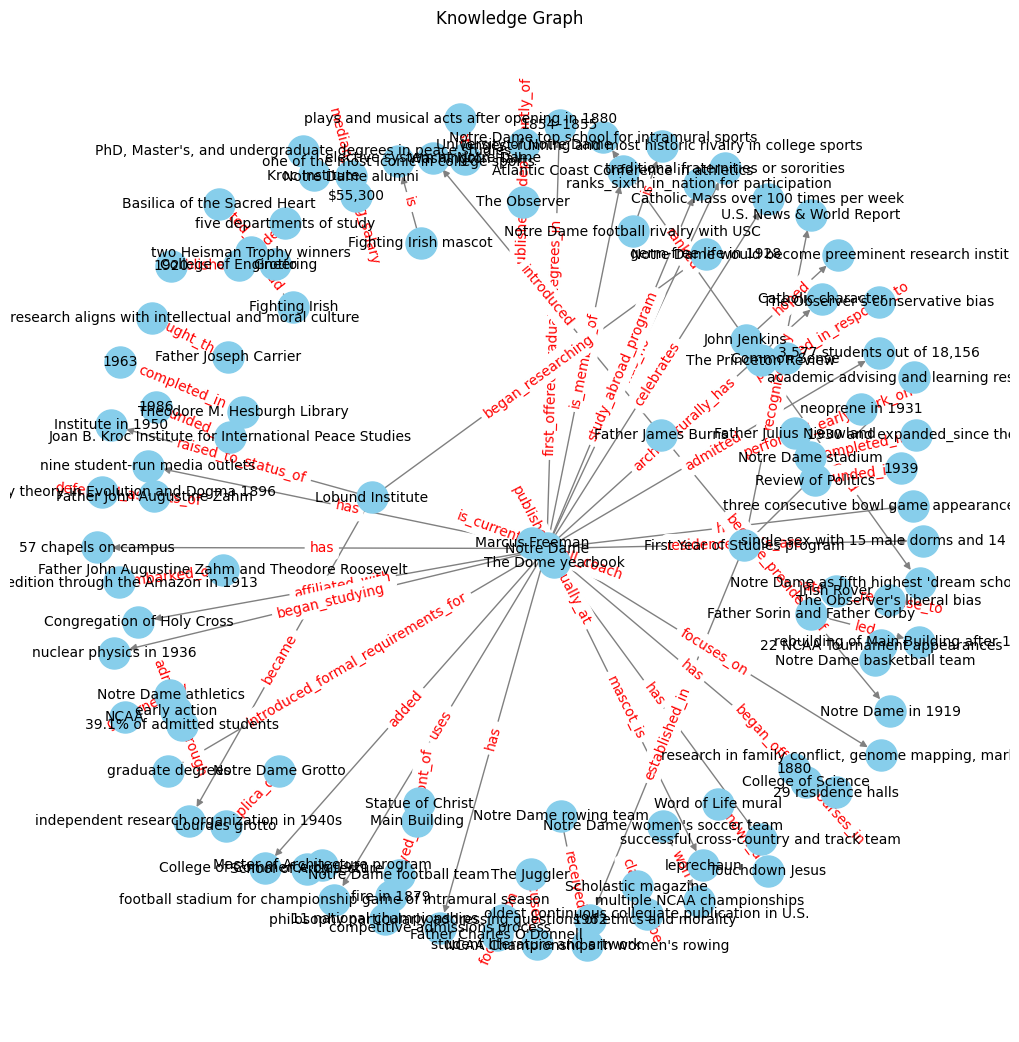

In [10]:
# visualize .csv file using networkx

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load the relations from the CSV file
relations_df = pd.read_csv("relations_2.csv")

# Create a directed graph
G = nx.from_pandas_edgelist(relations_df, 'Head', 'Tail', edge_attr='Relation', create_using=nx.DiGraph())

# Draw the graph
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, with_labels=True, node_size=500, font_size=10, node_color="skyblue", pos=pos, edge_color="gray", linewidths=1, font_color="black")
edge_labels = nx.get_edge_attributes(G, 'Relation')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=10)
plt.title("Knowledge Graph")
plt.show()

